In [2]:
import os
current_path = os.getcwd()
folder = "MA"
path =  folder.join(current_path.split(folder)[:-1])+folder
os.chdir(path)

In [3]:
import numpy as np
import pandas as pd
import statistics
from Scenarios.scenario_types.BaseScenario import BaseScenario
from Repair.Robust_PCA.robust_PCA_estimator import Robust_PCA_estimator   
from sklearn.decomposition import PCA


from matplotlib import pyplot as plt

In [4]:
scen = BaseScenario("YAHOO.csv")

['theisplots\\IMR.eps', 'outputfile_2', 'run.py', 'bayesiancomp', 'thesisplots', 'move_results.py', 'ParameterTuning', '.gitignore', 'myfile.txt', 'logs', 'run_ressources', 'notebooks', 'Scenarios', '.git', 'data_methods', 'varanomsizeampBayesianOptimization.svg', 'A_questions', 'myfile.toml', '__pycache__', 'README.md', 'Injection', '.idea', 'Repair', 'searchresults.csv', 'install.sh', 'screen_example2', 'Data', 'error_ranking.py']
Data/YAHOO.csv


In [5]:
n_components = 1
injected = scen.i_get_scenario(0)["injected"]


pca = PCA(n_components=n_components) 


transformed = pca.fit_transform(injected)
pca_predicted = pd.DataFrame(pca.inverse_transform(transformed))

<AxesSubplot:>

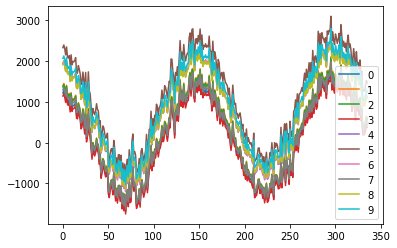

In [6]:
pca_predicted.plot()

In [7]:
import numpy as np
from numpy import linalg as LA

# Centroid Decomposition, with the optional possibility of specifying truncation or usage of initial sign vectors
def centroid_decomposition(matrix, truncation = 0, SV = None):
    # input processing
    matrix = np.asarray(matrix, dtype=np.float64).copy()
    n = len(matrix)
    m = len(matrix[0])
    
    if truncation == 0:
        truncation = m
    
    if truncation < 1 or truncation > m:
        print("[Centroid Decomposition] Error: invalid truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
        
    if SV is None:
        SV = default_SV(n, truncation)
    
    if len(SV) != truncation:
        print("[Centroid Decomposition] Error: provided list of Sign Vectors doesn't match in size with the truncation truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
    
    L = np.zeros((truncation, n))
    R = np.zeros((truncation, m))
    
    # main loop - goes up till the truncation param (maximum of which is the # of columns)
    for j in range(0, truncation):
        # calculate the sign vector
        Z = local_sign_vector(matrix, SV[j])
        
        # calculate the column of R by X^T * Z / ||X^T * Z||
        R_i = matrix.T @ Z
        R_i = R_i / np.linalg.norm(R_i)
        R[j] = R_i
        
        # calculate the column of L by X * R_i
        L_i = matrix @ R_i
        L[j] = L_i
        
        # subtract the dimension generated by L_i and R_i from the original matrix
        matrix = matrix - np.outer(L_i, R_i)
        
        # update the new sign vector in the array
        SV[j] = Z
    #end for
    
    return (L.T, R.T, SV)
#end function


# Algorithm: LSV (Local Sign Vector). Finds locally optimal sign vector Z, i.e.:
#   Z being locally optimal means: for all Z' sign vectors s.t. Z' is one sign flip away from Z at some index j,
#   we have that ||X^T * Z|| >= ||X^T * Z'||
def local_sign_vector(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    eps = np.finfo(np.float64).eps
    
    Z = local_sign_vector_init(matrix, Z)
        
    # calculate initial product of X^T * Z with the current version of Z
    direction = matrix.T @ Z
    # calculate initial value of ||X^T * Z|| #simply use the absolute value?
    lastNorm = np.linalg.norm(direction) ** 2 + eps
    print(direction)
    flipped = True
    
    while flipped:
        print("aaaa")
        # we terminate the loop if during the last pass we didn't flip a single sign
        flipped = False
        
        for i in range(0, n):
            signDouble = Z[i] * 2
            gradFlip = 0.0
            
            # calculate how ||X^T * Z|| would change if we would change the sign at position i
            # change to the values of D = X^T * Z is calculated as D_j_new = D_j - 2 * Z_i * M_ij for all j
            for j in range(0, m):
                localMod = direction[j] - signDouble * matrix[i][j]
                gradFlip += localMod * localMod
            
            # if it results in augmenting ||X^T * Z||
            # flip the sign and replace cached version of X^T * Z and its norm
            if gradFlip > lastNorm:
                flipped = True
                Z[i] = Z[i] * -1
                lastNorm = gradFlip + eps
                
                for j in range(0, m):
                    direction[j] -= signDouble * matrix[i][j]
                #end for
            #end if
        #end for
    #end while
    
    return Z
#end function


# Auxiliary function for LSV:
#   Z is initialized sequentiually where at each step we see which sign would give a larger increase to ||X^T * Z||
def local_sign_vector_init(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    direction = matrix[0] *1#*1 t
    
    for i in range(1, n):
        gradPlus = 0.0
        gradMinus = 0.0
        
        for j in range(0, m):
            localModPlus = direction[j] + matrix[i][j]
            gradPlus += localModPlus * localModPlus
            localModMinus = direction[j] - matrix[i][j]
            gradMinus += localModMinus * localModMinus
                
        if gradMinus > gradPlus:
            Z[i] = -1
        
        for j in range(0, m):
            direction[j] += Z[i] * matrix[i][j]
    
    return Z
#end function


#initialize sign vector array with default values
def default_SV(n, k):
    # default sign vector is (1, 1, ..., 1)^T
    baseZ = np.array([1.0] * n)
    SV = []
    
    for i in range(0, k):
        SV.append(baseZ.copy())
    
    return SV
#end function

def main():
    matrix = np.loadtxt("matrix_100K.txt")
    L, R, Z = centroid_decomposition(matrix)

    np.savetxt("matrix_100K.L.txt", L, fmt="%10.5f")
    np.savetxt("matrix_100K.R.txt", R, fmt="%10.5f")
    #np.savetxt("matrix_100K.Z.txt", np.asarray(Z).T, fmt="%5.1f")


In [32]:
matrix = injected.values
L, R, Z = centroid_decomposition(matrix, truncation = 3)
Z
np.linalg.matrix_rank(Z)

3

In [47]:
x = np.matmul(L,R.T)
np.linalg.matrix_rank(matrix)

np.matmul(matrix,R)-L
                   

[[5329.28923376  123.58223709  385.28148137]
 [5537.93258745  224.6610412   459.4086785 ]
 [5254.8075352   116.10361805   86.34026441]
 ...
 [2628.18333137 1161.09628008  285.35959928]
 [3044.58093355 1291.4687541  -461.37076587]
 [2860.73779253 1279.1561184  -742.65715101]]


array([[ 0.00000000e+00, -2.61479727e-12,  5.11590770e-13],
       [ 0.00000000e+00, -2.47268872e-12,  4.54747351e-13],
       [ 0.00000000e+00, -2.77111667e-12,  5.54223334e-13],
       ...,
       [ 4.54747351e-13, -1.36424205e-12,  1.70530257e-13],
       [ 0.00000000e+00, -1.59161573e-12,  1.13686838e-13],
       [ 0.00000000e+00, -1.81898940e-12,  1.13686838e-13]])

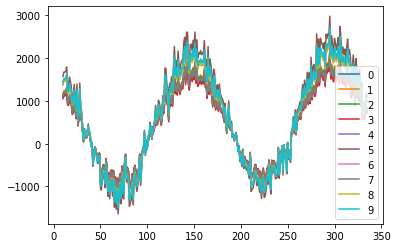

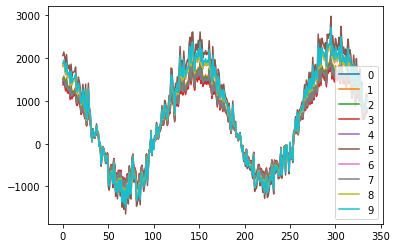

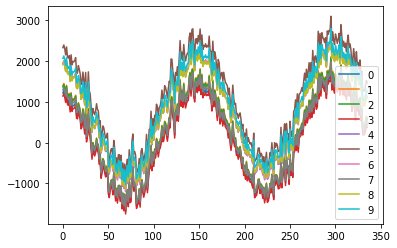

<AxesSubplot:>

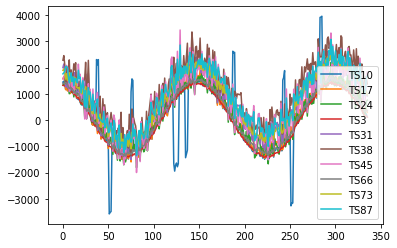

In [10]:
repair = pd.DataFrame(x).iloc[10:,:]
repair.plot()
plt.show()
pd.DataFrame(x).plot()
plt.show()
pca_predicted.plot()
plt.show()

injected.plot()

#scen.scenarios

In [11]:
(repair.shape , pca_predicted.shape)


((326, 10), (336, 10))

In [12]:
# Centroid Decomposition, with the optional possibility of specifying truncation or usage of initial sign vectors
def abs_centroid_decomposition(matrix, truncation = 0, SV = None):
    # input processing
    matrix = np.asarray(matrix, dtype=np.float64).copy()
    n = len(matrix)
    m = len(matrix[0])
    
    if truncation == 0:
        truncation = m
    
    if truncation < 1 or truncation > m:
        print("[Centroid Decomposition] Error: invalid truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
        
    if SV is None:
        SV = default_SV(n, truncation)
    
    if len(SV) != truncation:
        print("[Centroid Decomposition] Error: provided list of Sign Vectors doesn't match in size with the truncation truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
    
    L = np.zeros((truncation, n))
    R = np.zeros((truncation, m))
    
    # main loop - goes up till the truncation param (maximum of which is the # of columns)
    for j in range(0, truncation):
        # calculate the sign vector
        Z = abs_local_sign_vector(matrix, SV[j])
        
        # calculate the column of R by X^T * Z / ||X^T * Z||
        R_i = matrix.T @ Z
        R_i = R_i / np.linalg.norm(R_i)
        R[j] = R_i
        
        # calculate the column of L by X * R_i
        L_i = matrix @ R_i
        L[j] = L_i
        
        # subtract the dimension generated by L_i and R_i from the original matrix
        matrix = matrix - np.outer(L_i, R_i)
        
        # update the new sign vector in the array
        SV[j] = Z
    #end for
    
    return (L.T, R.T, SV)
#end function


# Algorithm: LSV (Local Sign Vector). Finds locally optimal sign vector Z, i.e.:
#   Z being locally optimal means: for all Z' sign vectors s.t. Z' is one sign flip away from Z at some index j,
#   we have that ||X^T * Z|| >= ||X^T * Z'||
def abs_local_sign_vector(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    eps = np.finfo(np.float64).eps
    
    Z = local_sign_vector_init(matrix, Z)
        
    # calculate initial product of X^T * Z with the current version of Z
    direction = matrix.T @ Z
    # calculate initial value of ||X^T * Z|| #simply use the absolute value?
    lastNorm = np.linalg.norm(direction,ord=1)+eps #np.linalg.norm(direction) ** 2 + eps
    flipped = True
    
    while flipped:
        print("eyyy")
        # we terminate the loop if during the last pass we didn't flip a single sign
        flipped = False
        
        for i in range(0, n):
            signDouble = Z[i] * 2
            gradFlip = 0.0
            
            # calculate how ||X^T * Z|| would change if we would change the sign at position i
            # change to the values of D = X^T * Z is calculated as D_j_new = D_j - 2 * Z_i * M_ij for all j
            for j in range(0, m):
                localMod = direction[j] - signDouble * matrix[i][j]
                #print(localMod)
                gradFlip += np.abs(localMod)
            #print(gradFlip)

            # if it results in augmenting ||X^T * Z||
            # flip the sign and replace cached version of X^T * Z and its norm
            if gradFlip > lastNorm:
                flipped = True
                Z[i] = Z[i] * -1
                lastNorm = gradFlip + eps
                
                for j in range(0, m):
                    direction[j] -= signDouble * matrix[i][j]
                #end for
            #end if
        #end for
    #end while
    
    return Z
#end function


# Auxiliary function for LSV:
#   Z is initialized sequentiually where at each step we see which sign would give a larger increase to ||X^T * Z||
def local_sign_vector_init(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    direction = matrix[0]*1#np.ones_like(matrix[0]) #matrix[0] *1 
    
    for i in range(1, n):
        gradPlus = 0.0
        gradMinus = 0.0
        
        for j in range(0, m):
            localModPlus = direction[j] + matrix[i][j]
            gradPlus +=  np.abs(localModPlus)
            localModMinus = direction[j] - matrix[i][j]
            gradMinus += np.abs(localModMinus)
                
        if gradMinus > gradPlus:
            Z[i] = -1
        
        for j in range(0, m):
            direction[j] += Z[i] * matrix[i][j]
    
    return Z
#end function


#initialize sign vector array with default values
def default_SV(n, k):
    # default sign vector is (1, 1, ..., 1)^T
    baseZ = np.array([1.0] * n)
    SV = []
    
    for i in range(0, k):
        SV.append(baseZ.copy())
    
    return SV
#end function

In [13]:
matrix = injected.values
col_mean = matrix.mean(axis=0)
matrix = matrix-col_mean
truncation =3
L_abs, R_abs, Z_abs = abs_centroid_decomposition(matrix*1, truncation = truncation)
x_abs = pd.DataFrame(np.matmul(L_abs,R_abs.T)+col_mean)
L, R, Z = centroid_decomposition(matrix*1, truncation = truncation)
x = pd.DataFrame(np.matmul(L,R.T)+col_mean)
print(sum(abs(Z[0]-Z_abs[0])))

print(R_abs)
print(R)
col_mean

eyyy
eyyy
eyyy
eyyy
[271055.17810677 301321.88079781 297208.02323297 293446.02455453
 312938.32314515 320456.96451309 306051.47653324 295780.97429999
 307986.166159   307528.1159556 ]
aaaa
[ 94526.42304835  -3132.42601575  10437.50706563  31731.92867455
 -41929.70258747 -64115.02827248 -19135.83080696  25761.27221539
  -8312.644876    -8542.87495072]
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
[102016.44767306   9758.19048528 -11210.34319616  30968.38461361
 -18739.8991053  -35178.95309897 -59895.32742192  22641.31918751
   5117.99912877 -29761.52584737]
aaaa
aaaa
aaaa
0.0
[[ 0.28415631  0.69074453  0.50388166]
 [ 0.31588592 -0.0509329   0.12431153]
 [ 0.31157323  0.11631164 -0.31615669]
 [ 0.3076294   0.23209055 -0.08529605]
 [ 0.32806383 -0.3544977   0.28222413]
 [ 0.33594588 -0.52727411  0.36633499]
 [ 0.32084412 -0.06183799 -0.53170373]
 [ 0.3100772   0.19348759 -0.11285908]
 [ 0.32287232 -0.08673661  0.10927947]
 [ 0.32239213 -0.02030245 -0.3196555 ]]
[[ 0.28415631  0.23950236  0.8290

array([ 145.05210947,  282.51128251,  265.56359339,   75.24071696,
        777.70038436, 1135.05745319,  781.97783367,  217.78174638,
        781.68337832,  920.53390886])

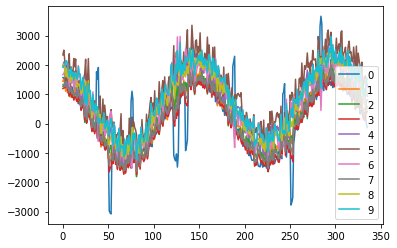

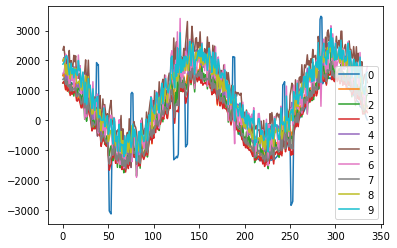

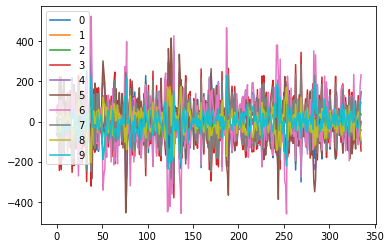

45

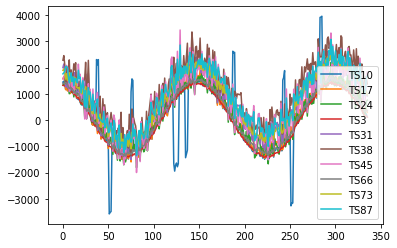

In [14]:
x_abs.plot()
plt.show()
x.plot()
plt.show()
(x-x_abs).plot()
plt.show()
injected.plot()
sum(abs(x_abs-x))

In [15]:
R_abs.T @ R_abs


array([[ 1.00000000e+00, -3.65601999e-17,  1.75326659e-16],
       [-3.65601999e-17,  1.00000000e+00, -2.11407268e-16],
       [ 1.75326659e-16, -2.11407268e-16,  1.00000000e+00]])

In [16]:
matrix= np.random.randint(-5,13,(6,3))

In [17]:
z =  np.random.randint(0,2,(6,))
z = z*2-1
print(z)
direction = matrix.T @ z
last_norm = np.linalg.norm(direction) ** 2

direction_m = matrix.T @ -z
last_norm_m = np.linalg.norm(direction_m) ** 2
last_norm , last_norm

[ 1  1 -1 -1  1 -1]


(392.0, 392.0)

In [18]:
# Centroid Decomposition, with the optional possibility of specifying truncation or usage ofitial sign vectors

delta = 10
delta_half_square = 1/2*delta**2 

def vec_call(x):
    smaller = x <= delta
    bigger = np.invert(smaller)
    result = np.zeros_like(x)
    result[smaller] =  x[smaller] ** 2 / 2.
    result[bigger] = delta * x[bigger] - delta_half_square
    return result 

def weight(x):
    x_flt = float(x)
    #assert x_flt >= 0
    if x_flt <= delta:
        return 1.0
    else:
        return delta / x_flt
    
vectorized_weights = np.vectorize(weight)

        
def centroid_decomposition_weighted(matrix, truncation = 0, SV = None):
    # input processing
    matrix = np.asarray(matrix, dtype=np.float64).copy()
    n = len(matrix)
    m = len(matrix[0])
    
    if truncation == 0:
        truncation = m
    
    if truncation < 1 or truncation > m:
        print("[Centroid Decomposition] Error: invalid truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
        
    if SV is None:
        SV = default_SV(n, truncation)
    
    if len(SV) != truncation:
        print("[Centroid Decomposition] Error: provided list of Sign Vectors doesn't match in size with the truncation truncation parameter k=" + str(truncation))
        print("[Centroid Decomposition] Aboritng decomposition")
        return None
    

    
    # main loop - goes up till the truncation param (maximum of which is the # of columns)
    w = None
    w = np.ones(n)/n
    for i in range(10):
        L = np.zeros((truncation, n))
        R = np.zeros((truncation, m))
    
        for j in range(0, truncation):
            # calculate the sign vector
            weighted_matrix = (matrix.T*w).T
            assert matrix.shape == matrix.shape 
            Z = local_sign_vector(weighted_matrix, SV[j])
            if w is None:
                w = np.ones_like(Z)
            plt.plot(w)
            # calculate the column of R by X^T * Z / ||X^T * Z||
            R_i = weighted_matrix.T @ Z
            R_i = R_i / np.linalg.norm(R_i)
            R[j] = R_i

            # calculate the column of L by X * R_i
            L_i = matrix @ R_i
            L[j] = L_i

            # subtract the dimension generated by L_i and R_i from the original matrix
            weighted_matrix = weighted_matrix - np.outer(L_i, R_i)
            # update the new sign vector in the array
            SV[j] = Z
            #end for
        
        #update weights
        errors_raw = np.linalg.norm(weighted_matrix, axis=1)
        errors_loss = vec_call(errors_raw)
        w = vectorized_weights(errors_raw)
        w /= w.sum()
        plt.show()
        plt.plot(w)
        plt.show()
        
        
            
    return (L.T, R.T, SV)
#end function


# Algorithm: LSV (Local Sign Vector). Finds locally optimal sign vector Z, i.e.:
#   Z being locally optimal means: for all Z' sign vectors s.t. Z' is one sign flip away from Z at some index j,
#   we have that ||X^T * Z|| >= ||X^T * Z'||
def local_sign_vector(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    eps = np.finfo(np.float64).eps
    
    Z = local_sign_vector_init(matrix, Z)
        
    # calculate initial product of X^T * Z with the current version of Z
    direction = matrix.T @ Z
    # calculate initial value of ||X^T * Z|| #simply use the absolute value?
    lastNorm = np.linalg.norm(direction) ** 2 + eps
    #print(direction)
    flipped = True
    
    while flipped:
        # we terminate the loop if during the last pass we didn't flip a single sign
        flipped = False
        for i in range(0, n):
            signDouble = Z[i] * 2
            gradFlip = 0.0
            
            # calculate how ||X^T * Z|| would change if we would change the sign at position i
            # change to the values of D = X^T * Z is calculated as D_j_new = D_j - 2 * Z_i * M_ij for all j
            for j in range(0, m):
                localMod = direction[j] - signDouble * matrix[i][j]
                gradFlip += localMod * localMod
            
            # if it results in augmenting ||X^T * Z||
            # flip the sign and replace cached version of X^T * Z and its norm
            if gradFlip > lastNorm:
                flipped = True
                Z[i] = Z[i] * -1
                lastNorm = gradFlip + eps
                
                for j in range(0, m):
                    direction[j] -= signDouble * matrix[i][j]
                #end for
            #end if
        #end for
    #end while
    
    return Z
#end function


# Auxiliary function for LSV:
#   Z is initialized sequentiually where at each step we see which sign would give a larger increase to ||X^T * Z||
def local_sign_vector_init(matrix, Z):
    n = len(matrix)
    m = len(matrix[0])
    direction = matrix[0]*1# else its a reference
    
    for i in range(1, n):
        gradPlus = 0.0
        gradMinus = 0.0
        
        for j in range(0, m):
            localModPlus = direction[j] + matrix[i][j]
            gradPlus += localModPlus * localModPlus
            localModMinus = direction[j] - matrix[i][j]
            gradMinus += localModMinus * localModMinus
                
        if gradMinus > gradPlus:
            Z[i] = -1
        
        for j in range(0, m):
            direction[j] += Z[i] * matrix[i][j]
    
    return Z
#end function


#initialize sign vector array with default values
def default_SV(n, k):
    # default sign vector is (1, 1, ..., 1)^T
    baseZ = np.array([1.0] * n)
    SV = []
    
    for i in range(0, k):
        SV.append(baseZ.copy())
    
    return SV
#end function

def main():
    matrix = np.loadtxt("matrix_100K.txt")
    L, R, Z = centroid_decomposition(matrix)

    np.savetxt("matrix_100K.L.txt", L, fmt="%10.5f")
    np.savetxt("matrix_100K.R.txt", R, fmt="%10.5f")


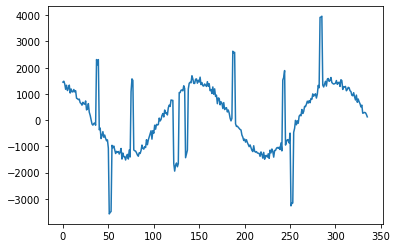

0.0


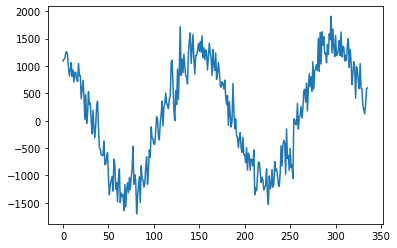

In [19]:
injected.iloc[:,0].plot()
plt.show()
class_ = scen.i_get_scenario(0)["class"]
matrix = injected.values
col_mean = matrix.mean(axis=0)
matrix = matrix-col_mean
truncation =2
#L_abs, R_abs, Z_abs = abs_centroid_decomposition(matrix*1, truncation = truncation)
#x_abs = pd.DataFrame(np.matmul(L_abs,R_abs.T)+col_mean)
L, R, Z = centroid_decomposition(matrix*1, truncation = truncation)
x = pd.DataFrame(np.matmul(L,R.T)+col_mean)
x.loc[:,0].plot()
print(sum(abs(Z[0]-Z_abs[0])))

eyyy


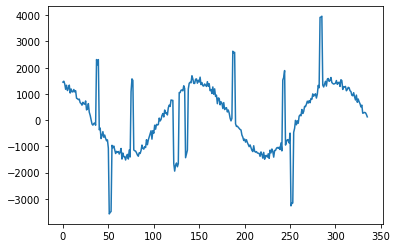

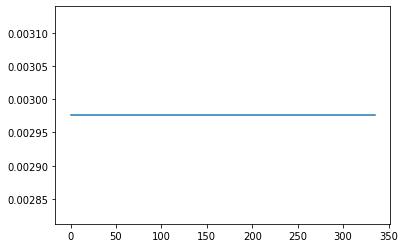

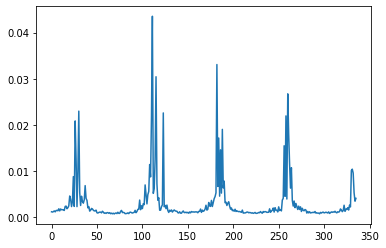

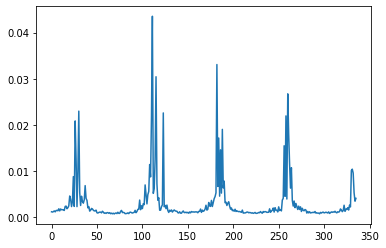

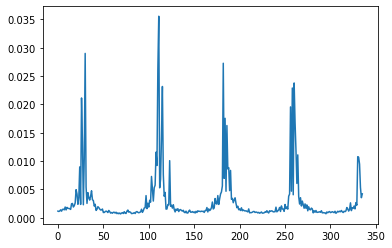

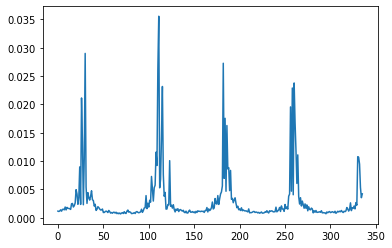

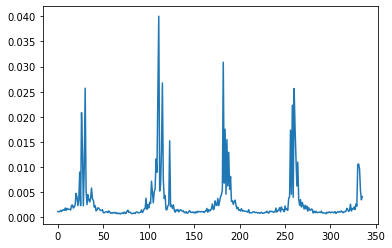

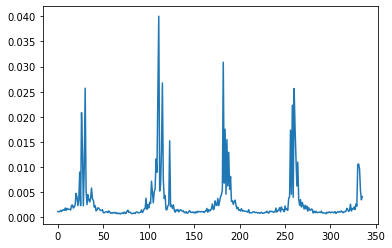

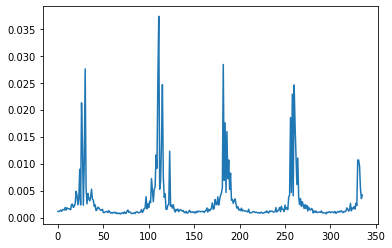

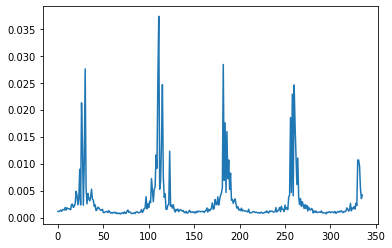

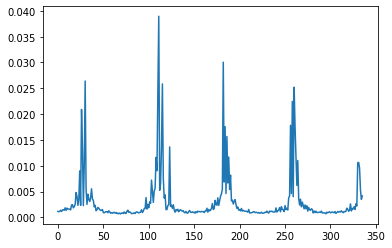

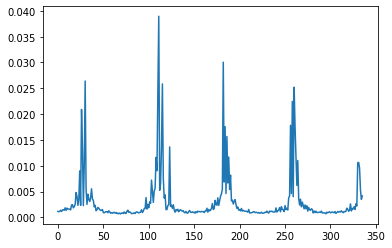

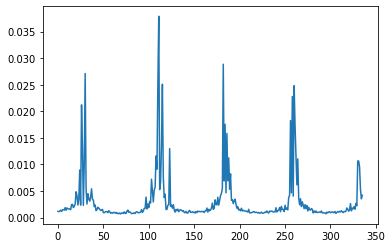

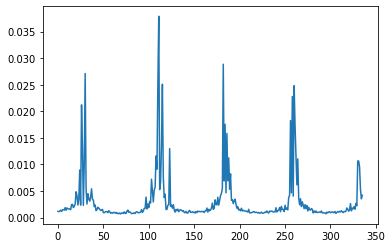

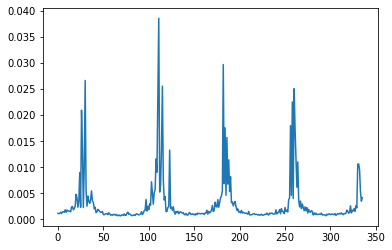

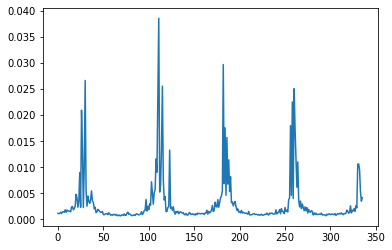

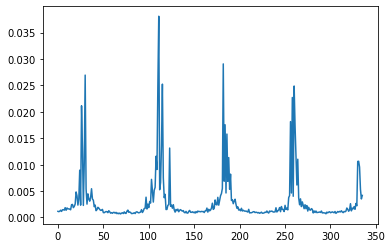

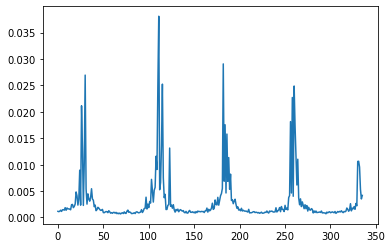

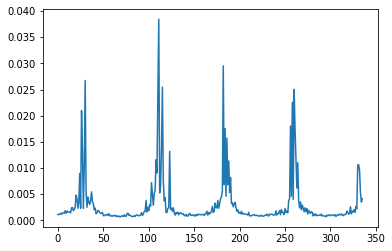

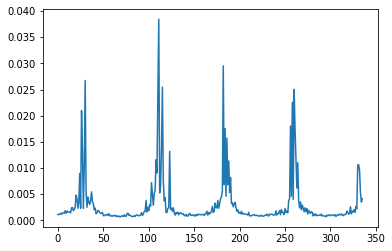

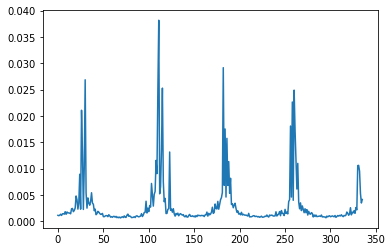

original
 0    793.569692
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6      0.000000
7      0.000000
8      0.000000
9      0.000000
dtype: float64
normal
 0    168.748939
1    153.754510
2    193.459998
3    178.272902
4    239.445615
5    312.496633
6    377.037177
7    153.928163
8    144.130937
9    215.376900
dtype: float64

abs
 0    168.748939
1    153.754510
2    193.459998
3    178.272902
4    239.445615
5    312.496633
6    377.037177
7    153.928163
8    144.130937
9    215.376900
dtype: float64
w
 0    304.130515
1    147.397660
2    194.596860
3    175.389958
4    235.714682
5    311.030391
6    379.913710
7    150.939088
8    143.144394
9    214.399204
dtype: float64


In [20]:
rmse = lambda x, y : ((x - y) ** 2).mean() ** .5
truth = scen.i_get_scenario(0)["original"]
truth.columns = list(range(len(truth.columns)))
injected.columns = list(range(len(injected.columns)))

matrix = injected.values
col_mean = matrix.mean(axis=0)
matrix = matrix-col_mean
truncation =1
L_abs, R_abs, Z_abs = abs_centroid_decomposition(matrix*1, truncation = truncation)
x_abs = pd.DataFrame(np.matmul(L_abs,R_abs.T)+col_mean)
L, R, Z = centroid_decomposition(matrix*1, truncation = truncation)
x = pd.DataFrame(np.matmul(L,R.T)+col_mean)


injected.loc[:,0].plot()
plt.show()
L_w, R_w, Z_w = centroid_decomposition_weighted(matrix*1, truncation = truncation)
x_w = pd.DataFrame(np.matmul(L_w,R_w.T)+col_mean)


print("original\n",rmse(injected,truth))


print("normal\n",rmse(x,truth))
print()

print("abs\n",rmse(x_abs,truth))
print("w\n",rmse(x_w,truth))



<AxesSubplot:>

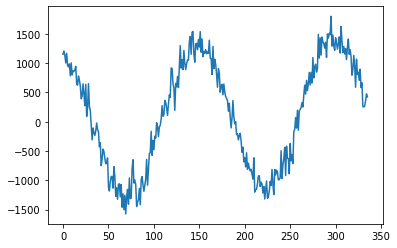

In [21]:
x_abs[0].plot()

<AxesSubplot:>

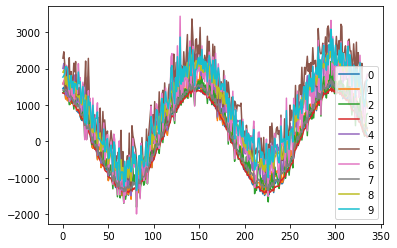

In [22]:
truth = scen.i_get_scenario(0)["original"]
truth.plot()

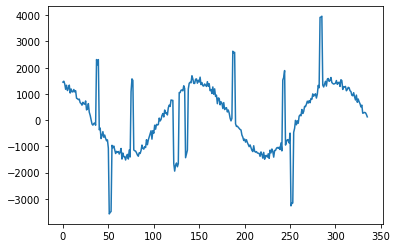

0.0


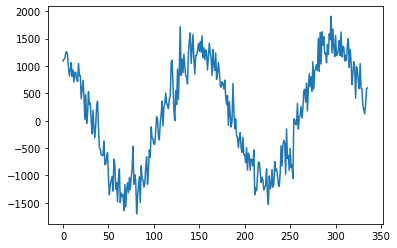

In [23]:
injected.iloc[:,0].plot()
plt.show()
class_ = scen.i_get_scenario(0)["class"]
matrix = injected.values
col_mean = matrix.mean(axis=0)
matrix = matrix-col_mean
truncation =2
#L_abs, R_abs, Z_abs = abs_centroid_decomposition(matrix*1, truncation = truncation)
#x_abs = pd.DataFrame(np.matmul(L_abs,R_abs.T)+col_mean)
L, R, Z = centroid_decomposition(matrix*1, truncation = truncation)
x = pd.DataFrame(np.matmul(L,R.T)+col_mean)
x.loc[:,0].plot()
print(sum(abs(Z[0]-Z_abs[0])))

In [24]:
from Repair.Dimensionality_Reduction.CDrec.recovery import centroid_recovery
class_ = scen.i_get_scenario(0)["class"]
matrix_nans = matrix.copy()
for col in range(class_.shape[1])
 matrix_nans[class_]= np.nan

m = centroid_recovery(matrix_nans)
scen.i_get_scenario(0)["injected"].plot()

SyntaxError: invalid syntax (3266104496.py, line 4)

In [ ]:
plt.plot(m)